<a href="https://colab.research.google.com/github/Nii-92/Data-integration-Assignment_Enoch-Nii/blob/main/Data_integration_assignment_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Upload the CSV file
from google.colab import files
uploaded = files.upload()


Saving ghana_owid.csv to ghana_owid.csv


In [2]:
# 2. Install and configure Spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()


In [3]:
# 3. Start Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Ghana COVID-19 Data Analysis") \
    .getOrCreate()


In [4]:
# 4. Read uploaded CSV
file_name = "ghana_owid.csv"

if file_name in uploaded:
    df = spark.read.csv(file_name, header=True, inferSchema=True)
    df.show(5)
else:
    print(f"File '{file_name}' was not uploaded.")


+--------+---------+---------+-------------------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+------------------------

In [5]:
# 5. Clean and prepare data
from pyspark.sql.functions import col, to_date

# Convert date column and drop rows with critical missing values
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

df_cleaned = df.dropna(subset=[
    "date", "new_cases", "total_cases", "new_deaths",
    "people_vaccinated", "aged_65_older", "aged_70_older",
    "cardiovasc_death_rate"
])

df_cleaned.select(
    "date", "new_cases", "total_cases", "new_deaths",
    "people_vaccinated", "aged_65_older", "aged_70_older"
).show(10)


+----------+---------+-----------+----------+-----------------+-------------+-------------+
|      date|new_cases|total_cases|new_deaths|people_vaccinated|aged_65_older|aged_70_older|
+----------+---------+-----------+----------+-----------------+-------------+-------------+
|2021-03-01|        0|      84349|         0|              0.0|        3.385|        1.948|
|2021-03-08|        0|      86973|         0|         202252.0|        3.385|        1.948|
|2021-03-10|        0|      86973|         0|         300000.0|        3.385|        1.948|
|2021-03-18|        0|      88421|         0|         420000.0|        3.385|        1.948|
|2021-03-24|        0|      89893|         0|         500000.0|        3.385|        1.948|
|2021-04-07|        0|      91009|         0|         599128.0|        3.385|        1.948|
|2021-04-08|        0|      91009|         0|         647380.0|        3.385|        1.948|
|2021-04-09|        0|      91009|         0|         681211.0|        3.385|   

In [6]:
# 6. Register temp view for SQL queries
df_cleaned.createOrReplaceTempView("ghana_covid19")


In [7]:
# 7. Perform SQL queries
print("📅 Total new cases over time:")
spark.sql("""
    SELECT date, new_cases FROM ghana_covid19 ORDER BY date
""").show(10)

print("📊 Average new cases:")
spark.sql("""
    SELECT ROUND(AVG(new_cases), 2) AS avg_new_cases FROM ghana_covid19
""").show()

print("💀 Total deaths:")
spark.sql("""
    SELECT SUM(new_deaths) AS total_deaths FROM ghana_covid19
""").show()

print("🔍 Data for a specific date (e.g. 2021-10-01):")
spark.sql("""
    SELECT * FROM ghana_covid19 WHERE date = '2021-10-01'
""").show()

print("⚠️ Dates with more than 100 new cases:")
spark.sql("""
    SELECT date, new_cases FROM ghana_covid19 WHERE new_cases > 100 ORDER BY date
""").show(10)


📅 Total new cases over time:
+----------+---------+
|      date|new_cases|
+----------+---------+
|2021-03-01|        0|
|2021-03-08|        0|
|2021-03-10|        0|
|2021-03-18|        0|
|2021-03-24|        0|
|2021-04-07|        0|
|2021-04-08|        0|
|2021-04-09|        0|
|2021-04-11|      468|
|2021-04-12|        0|
+----------+---------+
only showing top 10 rows

📊 Average new cases:
+-------------+
|avg_new_cases|
+-------------+
|       119.34|
+-------------+

💀 Total deaths:
+------------+
|total_deaths|
+------------+
|          25|
+------------+

🔍 Data for a specific date (e.g. 2021-10-01):
+--------+---------+---------+----+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+----------

Pandas DataFrame:
  iso_code continent locationa        date  total_cases  new_cases  \
0      GHA    Africa     Ghana  2021-03-01        84349          0   
1      GHA    Africa     Ghana  2021-03-08        86973          0   
2      GHA    Africa     Ghana  2021-03-10        86973          0   
3      GHA    Africa     Ghana  2021-03-18        88421          0   
4      GHA    Africa     Ghana  2021-03-24        89893          0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0             443.429           611           0                3.857  ...   
1             374.857           662           0                7.286  ...   
2             374.857           662           0                7.286  ...   
3             206.857           705           0                6.143  ...   
4             210.286           734           0                4.143  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0           7.7            

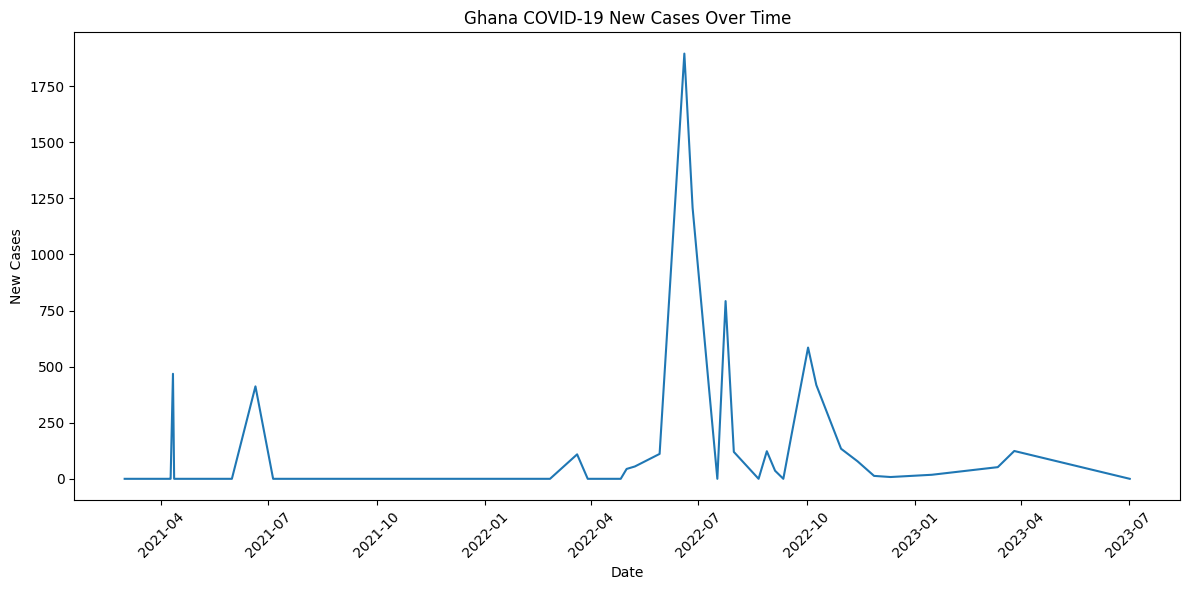

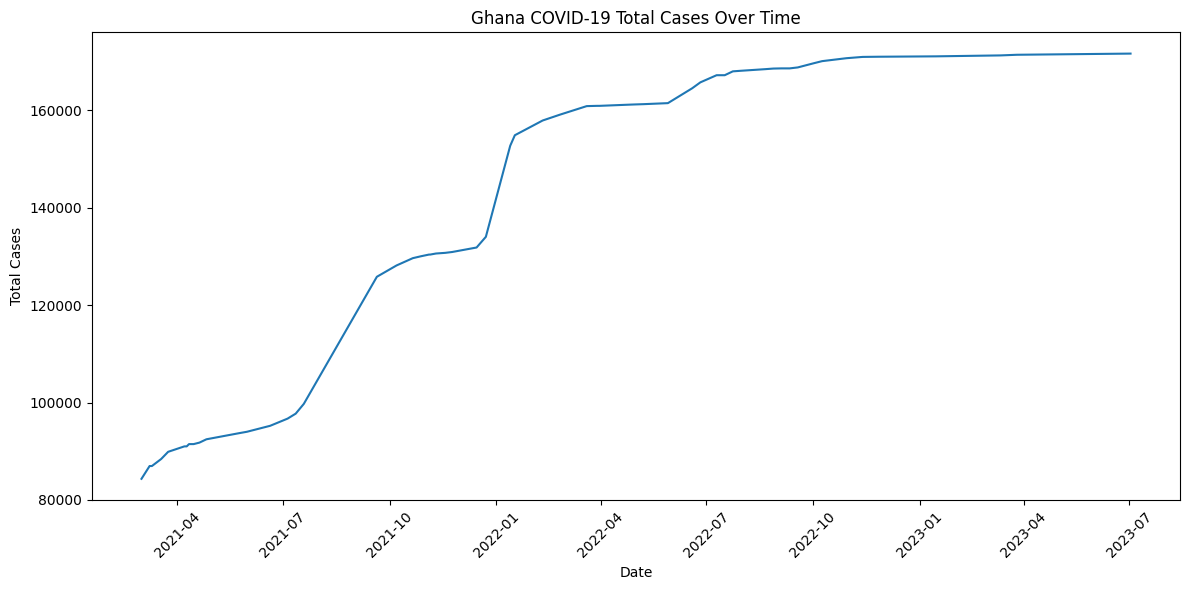

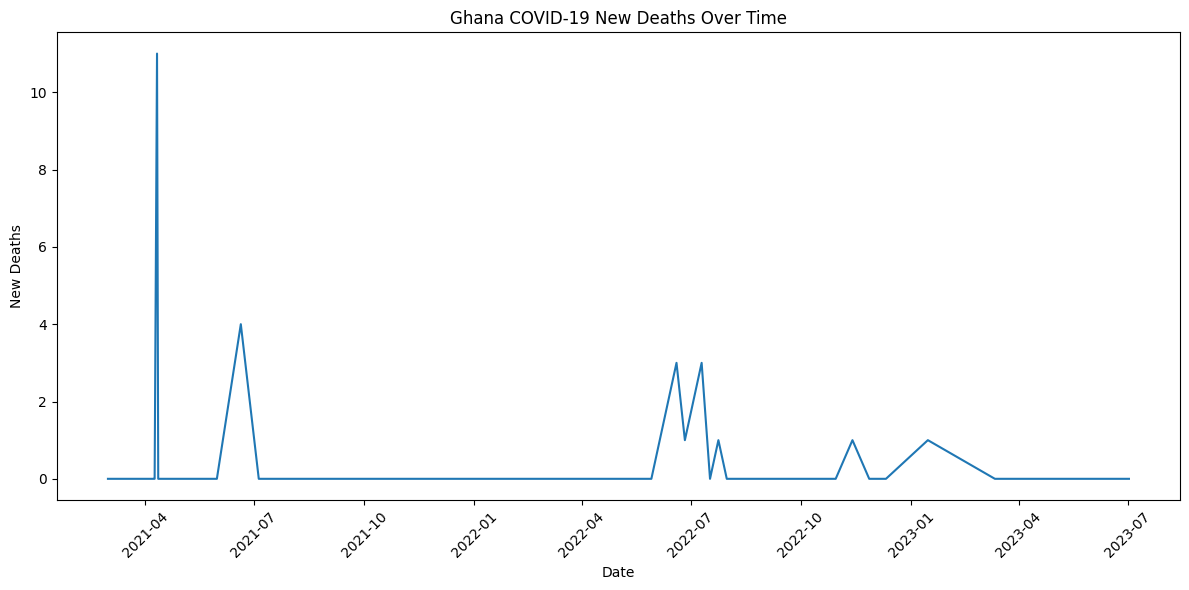

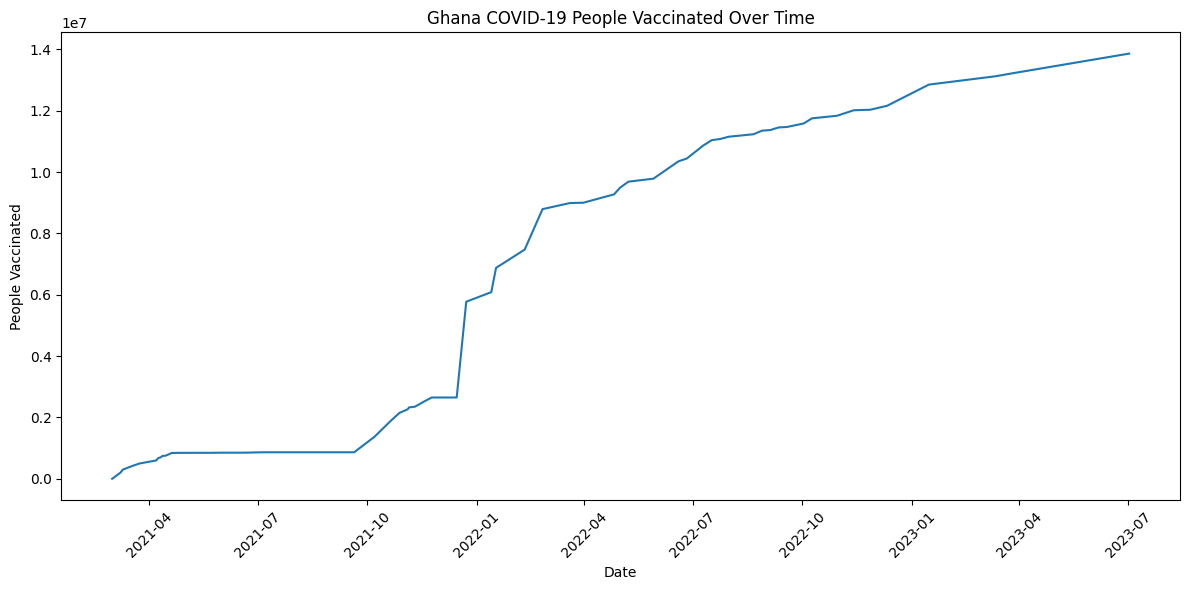

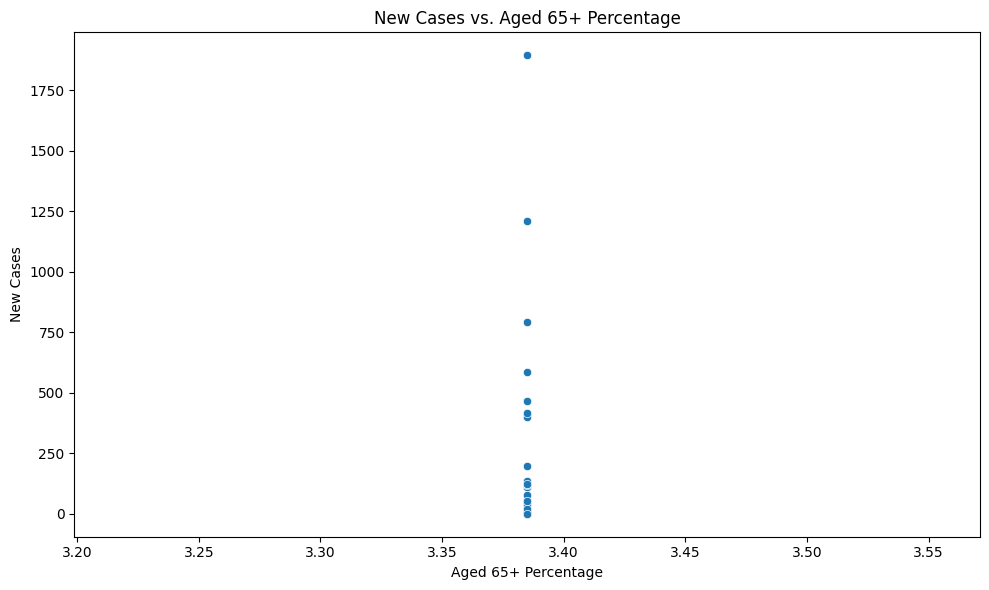

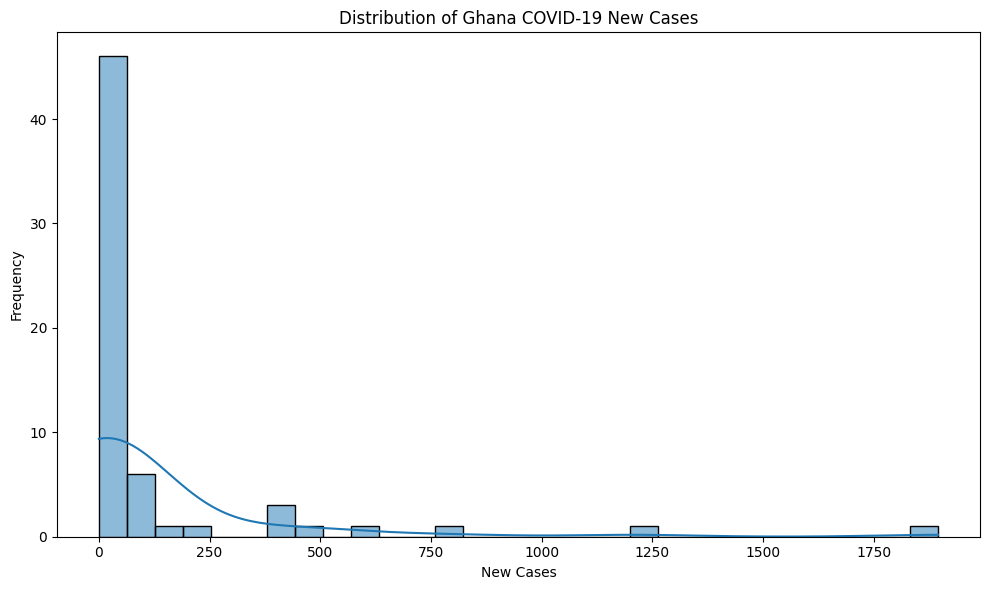

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = df_cleaned.toPandas()

print("Pandas DataFrame:")
print(pandas_df.head())


plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='new_cases')
plt.title('Ghana COVID-19 New Cases Over Time')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='total_cases')
plt.title('Ghana COVID-19 Total Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=pandas_df, x='date', y='new_deaths')
plt.title('Ghana COVID-19 New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if 'people_vaccinated' in pandas_df.columns and pandas_df['people_vaccinated'].notna().any():
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=pandas_df.dropna(subset=['people_vaccinated']), x='date', y='people_vaccinated')
    plt.title('Ghana COVID-19 People Vaccinated Over Time')
    plt.xlabel('Date')
    plt.ylabel('People Vaccinated')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("People vaccinated data is not available for plotting.")

if 'aged_65_older' in pandas_df.columns and pandas_df['aged_65_older'].notna().any():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pandas_df.dropna(subset=['new_cases', 'aged_65_older']), x='aged_65_older', y='new_cases')
    plt.title('New Cases vs. Aged 65+ Percentage')
    plt.xlabel('Aged 65+ Percentage')
    plt.ylabel('New Cases')
    plt.tight_layout()
    plt.show()
else:
    print("Aged 65+ percentage data is not available for plotting.")

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x='new_cases', kde=True, bins=30)
plt.title('Distribution of Ghana COVID-19 New Cases')
plt.xlabel('New Cases')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Introduction

This document outlines a data analysis project focused on exploring COVID-19 data for Ghana. Utilizing Apache Spark on Google Colaboratory, the project aims to process, clean, and analyze a dataset containing key indicators like new cases, total cases, new deaths, and vaccination figures. The analysis will involve data cleaning, performing exploratory SQL queries, and generating visualizations to understand trends and patterns of the pandemic in Ghana.

System Design

The system utilizes a client-server architecture where the Google Colaboratory environment acts as the client and the Spark cluster, set up within the Colaboratory instance, acts as the server.

1.Data Ingestion: The COVID-19 data is provided as a CSV file and uploaded directly to the Colaboratory environment.

2.Environment Setup: Apache Spark is installed and configured within the Colaboratory session, setting up the necessary environment variables for Java and Spark homes. findspark is used to make Spark discoverable within the Python environment.

3.Data Processing (Spark): The uploaded CSV file is read into a Spark DataFrame. Data cleaning is performed using Spark's DataFrame API, including converting the 'date' column to a proper date format and dropping rows with missing values in critical columns.

4.Analysis (Spark SQL and Pandas):

a. The cleaned Spark DataFrame is registered as a temporary SQL view, allowing for direct querying using Spark SQL. Several SQL queries are executed to extract basic statistics and filter data.

b. The cleaned Spark DataFrame is converted to a Pandas DataFrame for easier integration with visualization libraries.

5.Visualization (Matplotlib and Seaborn):

 Matplotlib and Seaborn are used to generate various plots (line plots, scatter plots, histograms) from the Pandas DataFrame to visualize trends in cases, deaths, vaccinations, and their potential correlation with demographic factors.

6.Output: Analysis results are printed to the console (from SQL queries) and visualizations are displayed as plots.


Implementation

The implementation is carried out within a Google Colaboratory notebook, leveraging its features for file uploads, package installation, and resource allocation.

1.File Upload: The google.colab.files.upload() function facilitates uploading the ghana_owid.csv file.

2.Spark Installation and Configuration:** Shell commands (`!apt-get`, `!wget`, `!tar`, `!pip`) are used to install Java, download and extract Spark, and install `findspark`. Environment variables are set using `os.environ`.

3.Spark Session Initialization: A Spark session is created using `SparkSession.builder`.

4.Data Loading and Cleaning: The `spark.read.csv()` method loads the data. DataFrame transformations like `withColumn` and `dropna` are applied for cleaning.

5.SQL Querying: The `createOrReplaceTempView()` method makes the data accessible via SQL. `spark.sql()` executes the SQL queries.

6.Pandas Conversion: The `toPandas()` method converts the Spark DataFrame to a Pandas DataFrame.

7.Visualization: Matplotlib's `plt` and Seaborn's `sns` are used to create plots based on the Pandas DataFrame. Error handling is included for columns that might be missing or entirely null.



#Challenges and Solutions

A. Challenge: Setting up and configuring Apache Spark within the Google Colaboratory environment.

Solution: Utilize shell commands to install necessary dependencies (Java), download Spark binaries, extract them, and set environment variables correctly. Using `findspark` simplifies the integration of Spark with the Python kernel.

B. Challenge: Handling potential missing values in the dataset, which could affect the analysis.


Solution: Employ the `dropna` method on the Spark DataFrame to remove rows where critical columns (identified as essential for the analysis) have missing values. This ensures that calculations and visualizations are based on complete data points for the chosen metrics.


C. Challenge: Performing both structured queries (SQL) and flexible data manipulation and visualization.


Solution: Leverage the interoperability between Spark DataFrames and Pandas DataFrames. Use Spark SQL for aggregation and filtering, and then convert to a Pandas DataFrame for convenient plotting with Matplotlib and Seaborn.

D. Challenge: Visualizing time-series data with date objects in Pandas.

Solution: Ensure the 'date' column is properly converted to a datetime format in both Spark and Pandas DataFrames. Matplotlib and Seaborn handle datetime axes effectively for line plots.

#Results: Analysis of Outputs, Performance Observations, and Insights Gained

The analysis yielded the following results:

a. Data Loading and Cleaning:** The initial rows of the loaded and cleaned Spark DataFrame were successfully displayed, confirming data ingestion and the effect of the cleaning process (removal of rows with missing critical data).

b. SQL Queries: The query showing total new cases over time demonstrated the progression of daily reported cases.

c. The average new cases query provided a single summary statistic of the daily case rate.

d. The total deaths query gave an aggregate measure of the pandemic's impact in terms of fatalities.

e. Querying for a specific date demonstrated the ability to retrieve detailed information for a particular day.

f. Identifying dates with more than 100 new cases highlighted periods of increased transmission.

g. Pandas DataFrame:** The head of the converted Pandas DataFrame was printed, confirming the successful transfer of data from Spark to Pandas.

#Visualizations:

a. The line plots for new cases, total cases, and new deaths over time clearly illustrated the trends and waves of the pandemic in Ghana.

b. The line plot for people vaccinated showed the progression of the vaccination rollout, where available.

c. The scatter plot of new cases vs. aged 65+ percentage, where data was available, could potentially reveal a correlation or lack thereof between these factors.

d. The histogram of new cases showed the distribution of daily case counts, indicating whether cases were typically low or high.

#Performance Observations:

For a dataset of this size (assuming it's not excessively large), the Spark processing within Colaboratory was reasonably fast. The overhead of setting up Spark is incurred once. Subsequent DataFrame operations and SQL queries executed efficiently. The conversion to Pandas (`toPandas()`) can be a bottleneck for very large datasets as it transfers all data to a single machine's memory. However, for this task, it was acceptable for visualization purposes.

Insights Gained:

The analysis provided insights into the timeline of the COVID-19 pandemic in Ghana, including periods of high and low case counts and deaths. The vaccination plot (if available) offered a view into the progress of public health efforts. The demographic analysis (aged 65+) could potentially reveal vulnerabilities in certain population segments, though this depends heavily on the completeness and accuracy of the data.

## Conclusion and Future Work

**Conclusion:**

This project successfully demonstrated the use of Apache Spark and its integration with Python libraries (Pandas, Matplotlib, Seaborn) within a Google Colaboratory environment for analyzing COVID-19 data for Ghana. The workflow involved data ingestion, cleaning, transformation, exploratory analysis using Spark SQL, and visualization using Pandas and plotting libraries. The process highlighted the strengths of Spark for handling structured data and performing basic aggregations, and the utility of Pandas for further manipulation and visualization.

Future Work:

1.More Advanced Analysis: Implement more complex Spark DataFrame operations or machine learning algorithms (e.g., time series forecasting of cases, correlation analysis with other factors like mobility data, economic indicators) to gain deeper insights.

2.Larger Datasets:** Test the scalability of the approach with larger or more complex datasets that might require distributed processing beyond what a single Colab instance can efficiently handle. This could involve using Google Cloud Dataproc or similar services.

3.Interactive Visualizations: Explore using interactive visualization libraries like Plotly or Bokeh to create more dynamic and explorable plots directly within the Colab notebook.

4.Data Source Integration: Instead of manual file upload, explore directly reading data from cloud storage (e.g., Google Cloud Storage, Amazon S3) or databases.

5.Parameterization: Make the analysis more flexible by allowing users to specify parameters like the country, date range, or specific metrics to analyze.

6.Error Handling: Add more robust error handling, particularly for file uploads and potential issues with data types or formats.
